# 06 - Grouped and Dummy Regression


## Regression With Grouped Data

Not all data points are created equal. If we look again at our ENEM dataset, we trust the scores of big schools much more than the scores from small schools. This is not to say that big schools are better or anything. It is just due to the fact that their big size imply less variance.

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from scipy import stats
from matplotlib import style
import seaborn as sns
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf

style.use("fivethirtyeight")

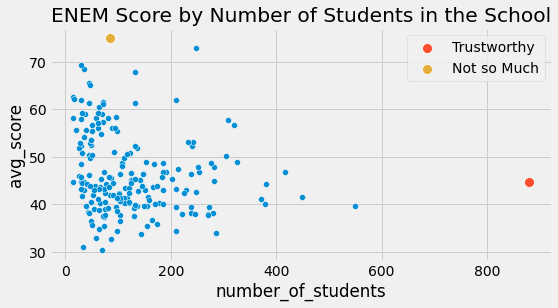

In [2]:
np.random.seed(876)
enem = pd.read_csv("./data/enem_scores.csv").sample(200)
plt.figure(figsize=(8,4))
sns.scatterplot(y="avg_score", x="number_of_students", data=enem)
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Trustworthy",
                data=enem.query(f"number_of_students=={enem.number_of_students.max()}"))
sns.scatterplot(y="avg_score", x="number_of_students", s=100, label="Not so Much",
                data=enem.query(f"avg_score=={enem.avg_score.max()}"))
plt.title("ENEM Score by Number of Students in the School");

In the data above, intuitively, points to the left should have less impact in my model than points to the right. In essence, points to the right are actually lots of other data points grouped into a single one. If we could unbundle them and run a linear regression on the ungrouped data, they would indeed contribute much more to the model estimation than an unbundled point in the left. 

This phenomenon of having a region of low variance and another of high variance is called **heteroskedasticity**. Put it simply, heteroskedasticity is when the variance is not constant across all values of the features. In the case above, we can see that the variance decreases as the feature sample size increases. To give another example of where we have heteroskedasticity, if you plot wage by age, you will see that there is higher wage variance for the old than for the young. But, by far, the most common reason for variance to differ is grouped data.

Grouped data like the one above are extremely common in data analysis. One reason for that is confidentiality. Governments and firms can't give away personal data because that would violate data privacy requirements they have to follow. If they need to export data to an outside researcher, they can only do it by means of grouping the data. This way, individuals get grouped together and are no longer uniquely identifiable.

Fortunately for us, regression can handle those kinds of data pretty well. To understand how, let's first take some ungrouped data like the one we had on wage and education. It contains one line per worker, so we know the wage for each individual in this dataset and also how many years of education he or she has.

In [3]:
wage = pd.read_csv("./data/wage.csv")[["wage", "lhwage", "educ", "IQ"]]

wage.head()

,wage,lhwage,educ,IQ
0,769,2.956212,12,93
1,808,2.782539,18,119
2,825,3.026504,14,108
3,650,2.788093,12,96
4,562,2.642622,11,74


If we run a regression model to figure out how education is associated with log hourly wages, we get the following result.

In [4]:
model_1 = smf.ols('lhwage ~ educ', data=wage).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.089,25.754,0.000,2.121,2.470
educ,0.0529,0.007,8.107,0.000,0.040,0.066


Now, let's pretend for a moment that this data was under some confidentiality constraint. The provider of it was not able to give individualised data. So we ask him instead to group everyone by years of education and give us only the mean log hourly wage and the number of individuals in each group. This leaves us with only 10 data points.

In [5]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "count":"count"})
              .reset_index())

group_wage

,educ,lhwage,count
0,9,2.856475,10
1,10,2.786911,35
2,11,2.855997,43
3,12,2.922168,393
4,13,3.021182,85
5,14,3.042352,77
6,15,3.090766,45
7,16,3.176184,150
8,17,3.246566,40
9,18,3.144257,57


Fear not! Regression doesn't need big data to work! What we can do is provide weights to our linear regression model. This way, it will consider groups with higher sample size more than the small groups. Notice how I've replaced the `smf.ols` with `smf.wls`, for weighted least squares. It's hard to notice, but it will make all the difference.

In [6]:
model_2 = smf.wls('lhwage ~ educ', data=group_wage, weights=group_wage["count"]).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.2954,0.078,29.327,0.000,2.115,2.476
educ,0.0529,0.006,9.231,0.000,0.040,0.066


Notice how the parameter estimate of `educ` in the grouped model is very close to the one in the ungrouped data (actually, they are the same in this case). Also, even with only 10 data points, we've managed to get a statistically significant coefficient. That's because, although we have fewer points, grouping also lowers the variance by a lot. Also notice how the standard error is a bit larger and the t statistics is a bit larger. That's because some information about the variance is lost, so we have to be more conservative. Once we group the data, we don't know how large the variance is within each group. Compare the results above with what we would have with the non weighted model below.

In [7]:
model_3 = smf.ols('lhwage ~ educ', data=group_wage).fit()
model_3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3650,0.082,28.988,0.000,2.177,2.553
educ,0.0481,0.006,8.136,0.000,0.034,0.062


The parameter estimate is smaller. What is happening here is that the regression is placing equal weight for all points. If we plot the model along the grouped points, we see that the non weighted model is giving more importance to  small points in the lower left than it should. As a consequence, the line has a lower slope.

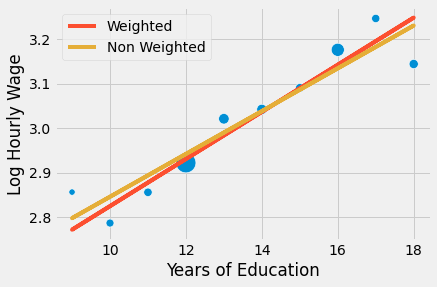

In [8]:
sns.scatterplot(x="educ", y = "lhwage", size="count", legend=False, data=group_wage, sizes=(40, 400))
plt.plot(wage["educ"], model_2.predict(wage["educ"]), c="C1", label = "Weighted")
plt.plot(wage["educ"], model_3.predict(wage["educ"]), c="C2", label = "Non Weighted")
plt.xlabel("Years of Education")
plt.ylabel("Log Hourly Wage")
plt.legend();

The bottom line is that regression is this marvellous tool that works both with individual or aggregated data, but you have to use weights in this last case. To use weighted regression you need mean statistics. Not sums, not standard deviations, not medians, but means! For both the covariates and the dependent variable. Just keep in mind that the result of weighted regression with grouped data won't match exactly that of regression in ungrouped data, but it will be pretty similar. 

![img](./data/img/dummy/heterosk.png)

I'll finish with a final example using additional covariates in a grouped data model.

In [9]:
group_wage = (wage
              .assign(count=1)
              .groupby("educ")
              .agg({"lhwage":"mean", "IQ":"mean", "count":"count"})
              .reset_index())

model_4 = smf.wls('lhwage ~ educ + IQ', data=group_wage, weights=group_wage["count"]).fit()
print("Number of observations:", model_4.nobs)
model_4.summary().tables[1]

Number of observations: 10.0


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.8821,0.324,5.800,0.001,1.115,2.649
educ,0.0257,0.021,1.198,0.270,-0.025,0.077
IQ,0.0077,0.006,1.309,0.232,-0.006,0.022


In this example, we've included IQ as a feature, besides the previously added years of education. The mechanics is pretty much the same: get the means and count, regress the mean and use the count as weights. 

## Regression for Dummies

Dummy variables are categorical variables we've encoded as binary columns. For example, suppose you have a gender variable that you wish to include in your model. This variable is encoded into 3 categories: male, female and other genders. 

|gender|
|------|
|male  |
|female|
|female|
|other |
|male  |

Since our model only accepts numerical values, we need to convert this category to a number. In linear regression, we use dummies for that. We encode each variable as a 0/1 column, denoting the presence of a category. We also leave one of the categories out as the base category. This is necessary since the last category is a linear combination of the others. Put it differently, we can know the last category if someone gives us information on the others. In our example, if someone is neither female nor other genders, we can infer that the person's category is male.

|gender|female|other|
|------|:-----|:----|
|male  |0|0|
|female|1|0|
|female|1|0|
|other |0|1|
|male  |0|0|

We've already dealt with a simple form of dummy regression when dealing with A/B testing. More generally, when we are dealing with a binary treatment, we represent it as a dummy variable. In this case, **the regression coefficient for that dummy is the increment for the intercept in the regression line**, or the difference in means between the treated and untreated.

To make this more concrete, consider the problem of estimating the effect of graduating 12th grade on hourly wage (and let's ignore confounding just for now). In the code below, we've created a treatment dummy variable `T` indicating if years of education is greater than 12. 

In [10]:
wage = (pd.read_csv("./data/wage.csv")
        .assign(hwage=lambda d: d["wage"] / d["hours"])
        .assign(T=lambda d: (d["educ"] > 12).astype(int)))

wage[["hwage", "IQ", "T"]].head()

,hwage,IQ,T
0,19.225,93,0
1,16.160,119,1
2,20.625,108,1
3,16.250,96,0
4,14.050,74,0


The dummy works as a kind of switch. In our example, if the dummy is on, the predicted value is the intercept plus the dummy coefficient. If the dummy is off, the predicted value is just the intercept. 

In [11]:
smf.ols('hwage ~ T', data=wage).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,19.9405,0.436,45.685,0.000,19.084,20.797
T,4.9044,0.626,7.830,0.000,3.675,6.134


In this case, when the person hasn't completed 12th grade (dummy off), the average income is 19.9. When he or she has completed 12th grade (dummy on), the predicted value or the average income is 24.8449 (19.9405 + 4.9044). Hence, the dummy coefficient captures the difference in means, which is 4.9044 in our case.

More formally, when the independent variable is binary, as is often the case with treatment indicators, regression captures the ATE perfectly. That is because regression is a linear approximation to the conditional expectation function (CEF) $E[Y|X]$ and, in this particular case, the CEF IS linear. Namely, we can define $E[Y_i|T_i=0]=\alpha$ and $E[Y_i|T_i=1] = \alpha + \beta$, which leads to the following CEF

$
E[Y_i|T_i] =  E[Y_i|T_i=0] + \beta T_i = \alpha + \beta T_i
$

and $\beta$ is the difference in means or the ATE in the case of random data

$
\beta = [Y_i|T_i=1] - [Y_i|T_i=0]
$

If we use additional variables, the dummy coefficient becomes the **conditional** difference in means. For instance, let's say we add IQ to the previous model. Now, the dummy coefficient tells us how much increase we should expect from graduating 12th grade **while holding IQ fixed**. If we plot the prediction, we will see two parallel lines. The jump from one line to the next says the amount we should expect for completing 12th grade. They also say that the effect is constant. No matter your IQ, everyone benefits the same from graduating 12th grade. 

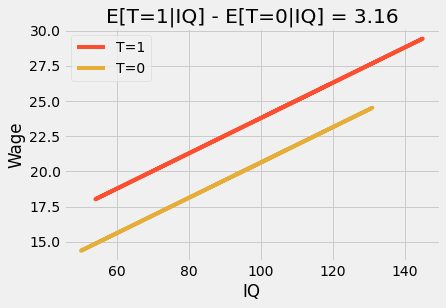

In [12]:
m = smf.ols('hwage ~ T+IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

If we put this model into an equation, we can see why:

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + e_i
$

Here, $\beta_1$ is the conditional difference in means and it is a constant value, 3.16 in our case. We can make this model more flexible by adding an interaction term.

$
wage_i = \beta_0 + \beta_1T_i + \beta_2 IQ_i + \beta_3 IQ_i * T_i  + e_i
$

Things are getting a little bit more complex, so let's see what each parameter means in this model. First, the intercept $\beta_0$. This bad boy doesn't have a particularly interesting interpretation. It's the expected wage when the treatment is zero (the person hasn't graduated from 12th grade) AND the IQ is zero. Since we don't expect IQ to be zero for anyone this parameter is not very meaningful. As for $\beta_1$, we have a similar situation. This parameter is how much increase in wage we should expect from completing 12th grade **when IQ is zero**. Once again, since IQ is never zero, it doesn't have a particularly interesting meaning. Now, $\beta_2$ is a bit more interesting. It tells us how much IQ increases wages **for the non-treated**. So, in our case, it is something like 0.11. This means that for each 1 extra IQ point, the person that has not completed 12th grade should expect to gain an extra 11 cents per hour. Finally, the most interesting parameter is $\beta_3$. It tells us how much IQ increases the effect of graduating 12th grade. In our case, this parameter is 0.024, which means that for each extra IQ point, graduating 12th grade gives 2 extra cents. This might not seem much, but compare someone with 60IQ and with 140IQ. The first one will get an increase of 1.44 in wage (60 * 0.024), while the person with 140 IQ will gain an extra 3.36 dollars (140 * 0.024) when graduating from 12th grade.

In simple modeling jargon, this interaction term allows the treatment effect to change by levels of the features (only IQ, in this example). The result is that if we plot the prediction lines, we will see that they are no longer parallel and that those that graduate 12th grade (T=1) have a higher slope on IQ, higher IQ benefit more from graduating than lower IQ. This is sometimes referenced as effect modification or heterogeneous treatment effect. 

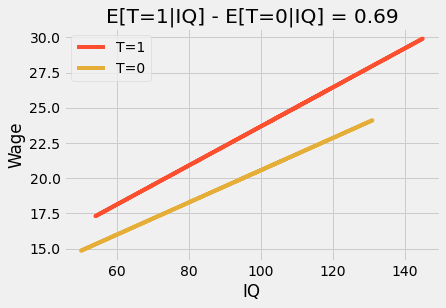

In [13]:
m = smf.ols('hwage ~ T*IQ', data=wage).fit()
plt_df = wage.assign(y_hat = m.fittedvalues)

plt.plot(plt_df.query("T==1")["IQ"], plt_df.query("T==1")["y_hat"], c="C1", label="T=1")
plt.plot(plt_df.query("T==0")["IQ"], plt_df.query("T==0")["y_hat"], c="C2", label="T=0")
plt.title(f"E[T=1|IQ] - E[T=0|IQ] = {round(m.params['T'], 2)}")
plt.ylabel("Wage")
plt.xlabel("IQ")
plt.legend();

Finally, let's look at the case where all the variables in our model are dummies. To do so, we will discretize IQ into 4 bins and treat years of education as a category.

In [14]:
wage_ed_bins = (wage
                .assign(IQ_bins = lambda d: pd.qcut(d["IQ"], q=4, labels=range(4)))
                [["hwage", "educ", "IQ_bins"]])

wage_ed_bins.head()

,hwage,educ,IQ_bins
0,19.225,12,1
1,16.160,18,3
2,20.625,14,2
3,16.250,12,1
4,14.050,11,0


Treating education as a category, we no longer restrict the effect of education to a single parameter. Instead, we allow each year of education to have its own distinct impact. By doing so, we gain flexibility, since the effect of education is no longer parametric. This model simply computes the mean wage for each year of education.

In [15]:
model_dummy = smf.ols('hwage ~ C(educ)', data=wage).fit()
model_dummy.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.5600,3.011,6.164,0.000,12.651,24.469
C(educ)[T.10],-0.7874,3.414,-0.231,0.818,-7.488,5.913
C(educ)[T.11],0.1084,3.343,0.032,0.974,-6.452,6.669
C(educ)[T.12],1.7479,3.049,0.573,0.567,-4.236,7.732
C(educ)[T.13],4.3290,3.183,1.360,0.174,-1.918,10.576
C(educ)[T.14],4.0888,3.200,1.278,0.202,-2.192,10.370
C(educ)[T.15],6.3013,3.329,1.893,0.059,-0.231,12.834
C(educ)[T.16],7.2225,3.110,2.323,0.020,1.120,13.325
C(educ)[T.17],9.5905,3.366,2.849,0.004,2.984,16.197
C(educ)[T.18],7.3681,3.264,2.257,0.024,0.962,13.775


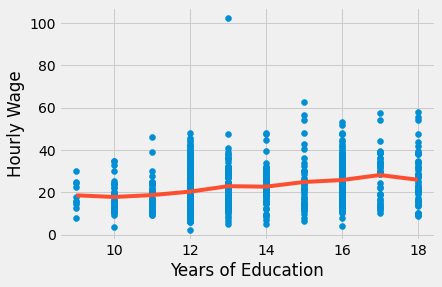

In [16]:
plt.scatter(wage["educ"], wage["hwage"])
plt.plot(wage["educ"].sort_values(), model_dummy.predict(wage["educ"].sort_values()), c="C1")
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage");

First of all, notice how this removes any assumption about the functional form of how education affects wages. We don't need to worry about logs anymore. In essence, this model is completely non-parametric. All it does is compute sample averages of wage for each year of education. This can be seen in the plot above, where the fitted line doesn't have a particular form. Instead, is the interpolation of the sample means for each year of education. We can also see that by reconstructing one parameter, for instance, that of 17 years of education. For this model, it's `9.5905`. Below, we can see how it is just the difference between the baseline years of education (9) and the individuals with 17 years

$
\beta_{17} = E[Y|T=17]-E[Y|T=9]
$

The trade-off is that we lose statistical significance when we allow such flexibility. Notice how big the p-values are for some years.

In [17]:
t1 = wage.query("educ==17")["hwage"]
t0 = wage.query("educ==9")["hwage"]
print("E[Y|T=9]:", t0.mean())
print("E[Y|T=17]-E[Y|T=9]:", t1.mean() - t0.mean())

E[Y|T=9]: 18.56
E[Y|T=17]-E[Y|T=9]: 9.590472362353516


If we include more dummy covariates in the model, the parameter on education become a weighted average of the effect on each dummy group:

$
E\{ \ (E[Y_i|T=1, Group_i] - E[Y_i|T=0, Group_i])w(Group_i) \ \}
$

$w(Group_i)$ is not exactly, but is proportional to the variance of the treatment in the group $Var(T_i|Group_i)$. One natural question that arises from this is why not use the full nonparametric estimator, where the group weight is the sample size? This indeed is a valid estimator, but it is not what regression does. By using the treatment variance, regression is placing more weight on groups where the treatment varies a lot. This makes intuitive sense. If the treatment was almost constant (say 1 treated and everyone else untreated), it doesn't matter its sample size. It wouldn't provide much information about the treatment effect.

In [18]:
model_dummy_2 = smf.ols('hwage ~ C(educ) + C(IQ_bins)', data=wage_ed_bins).fit()
model_dummy_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,18.4178,2.991,6.158,0.000,12.548,24.288
C(educ)[T.10],-1.2149,3.392,-0.358,0.720,-7.872,5.442
C(educ)[T.11],-0.4687,3.332,-0.141,0.888,-7.008,6.070
C(educ)[T.12],0.3400,3.059,0.111,0.912,-5.664,6.344
C(educ)[T.13],2.4103,3.206,0.752,0.452,-3.882,8.702
C(educ)[T.14],1.8040,3.238,0.557,0.578,-4.551,8.159
C(educ)[T.15],3.8599,3.369,1.146,0.252,-2.752,10.472
C(educ)[T.16],4.4060,3.171,1.390,0.165,-1.817,10.629
C(educ)[T.17],6.7470,3.422,1.971,0.049,0.030,13.464
C(educ)[T.18],4.3463,3.332,1.304,0.192,-2.194,10.886


![img](./data/img/dummy/you_little_shit.png)

## Key Ideas

We started this section by looking at how some data points are more important than others. Namely, those with higher sample size and lower variance should be given more weight when estimating a linear model. Then, we looked at how linear regression can even handle grouped anonymised data with elegance, provided we use sample weights in our model.

Next, we moved to dummy regression. We saw how it can be made a non parametric model that places no assumptions whatsoever on the functional form of how the treatment impacts the outcome. We then explored the intuition behind dummy regression.

## References

I like to think of this entire book as a tribute to Joshua Angrist, Alberto Abadie and Christopher Walters for their amazing Econometrics class. Most of the ideas here are taken from their classes at the American Economic Association. Watching them is what is keeping me sane during this tough year of 2020.
* [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
* [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

I'll also like to reference the amazing books from Angrist. They have shown me that Econometrics, or 'Metrics as they call it, is not only extremely useful but also profoundly fun.

* [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com/)
* [Mastering 'Metrics](https://www.masteringmetrics.com/)

My final reference is Miguel Hernan and Jamie Robins' book. It has been my trustworthy companion in the most thorny causal questions I had to answer.

* [Causal Inference Book](https://www.hsph.harvard.edu/miguel-hernan/causal-inference-book/)

![img](./data/img/poetry.png)

## Contribute

Causal Inference for the Brave and True is an open-source material on causal inference, the statistics of science. It uses only free software, based in Python. Its goal is to be accessible monetarily and intellectually.
If you found this book valuable and you want to support it, please go to [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true). If you are not ready to contribute financially, you can also help by fixing typos, suggesting edits or giving feedback on passages you didn't understand. Just go to the book's repository and [open an issue](https://github.com/matheusfacure/python-causality-handbook/issues). Finally, if you liked this content, please share it with others who might find it useful and give it a [star on GitHub](https://github.com/matheusfacure/python-causality-handbook/stargazers).

